In [1]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from basix.ufl import element, mixed_element
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista

import sys
import os

# Get the absolute path to the src directory
src_path = os.path.abspath('..')
if src_path not in sys.path:
    sys.path.append(src_path)

from typing import List, Tuple
from src.visualization import timeDependentVariableToGif, plot_array, plot_function
from src.solutionOperators import solveStateEquation, getSourceTerm, \
    buildControlFunction, solveAdjointEquation, solveStateEquationVV
#from src.solveFinDimObjective import solveFinDimProblem
from src.helpers import getValueOfFunction, buildIterationFunction, calculateL2InnerProduct
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import calculateL2InnerProduct, HesseMatrix
from src.semiSmoothNewtonSolver import computeSSNStep
from dataclasses import dataclass
from ufl import grad, inner, dx

@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    newton_c = 1
    eta = 0.01
    alpha = 2.2
    beta = 2.4
    waveSpeed = 1
    randomFactor = 0.05
    solverIteration = 0
    yd = []
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


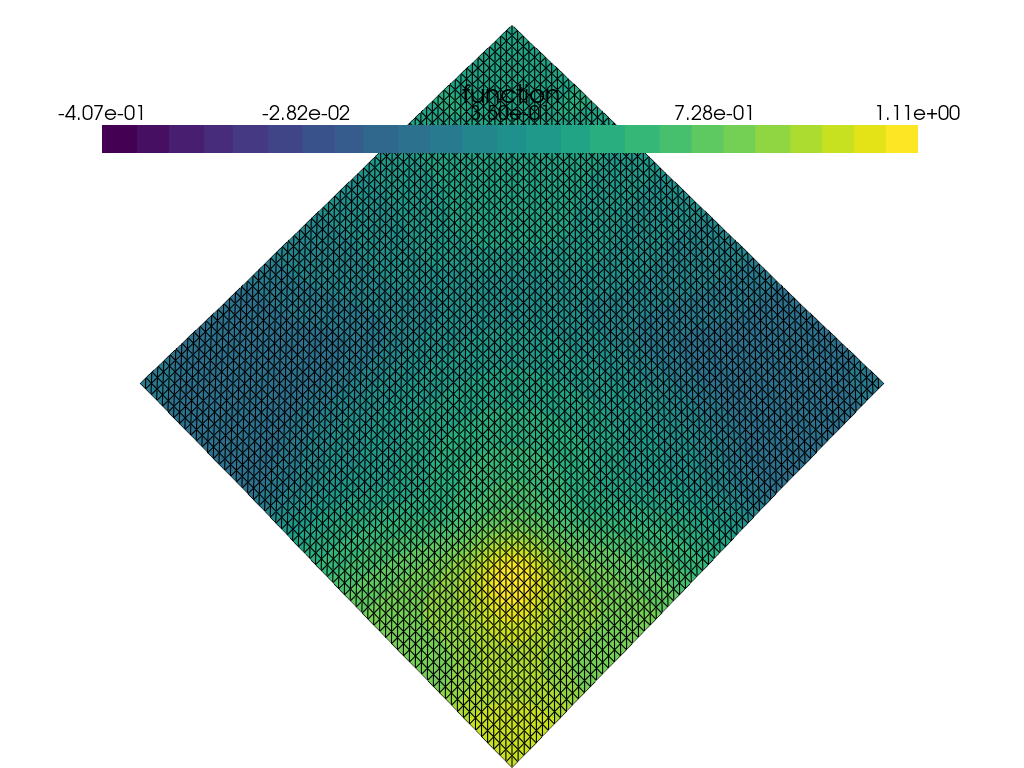

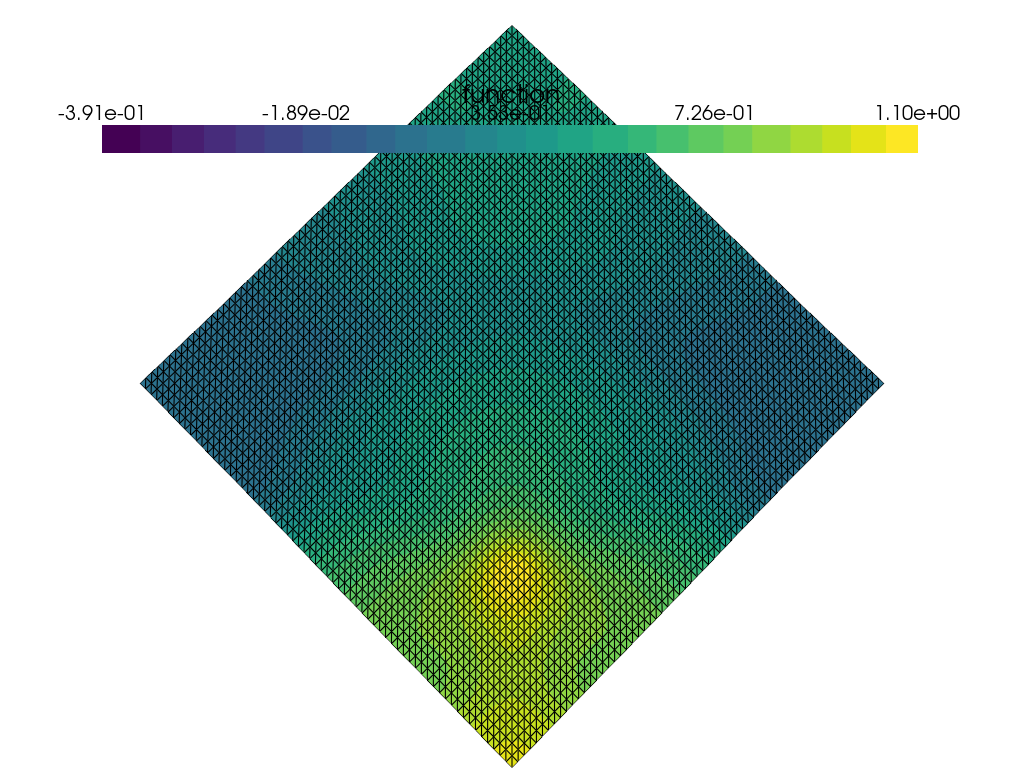

In [ ]:
'''
def solveStateEquationVV(control: List[fem.Function], params) -> List[fem.Function]:
	V_el = element("Lagrange", params.msh.basix_cell(), 1)
	V = fem.functionspace(params.msh, V_el)
	uStart = fem.Function(params.V)
	uStart.interpolate(lambda x : np.zeros(x[0].shape))
	solution = [uStart]
	P_el = element("Lagrange", params.msh.basix_cell(), 1)
	P = fem.functionspace(params.msh, P_el)
	W_el = mixed_element([V_el, P_el])
	W = fem.functionspace(params.msh, W_el)
	y0 = fem.Function(V)
	y0.interpolate(lambda x: np.zeros_like(x[0]))
	v0 = fem.Function(P)
	v0.interpolate(lambda x: np.zeros_like(x[0]))
	g = fem.Function(V)
	g.x.array[:] = control[0].x.array
	(eta, xi) = ufl.TestFunctions(W)
	(y, v) = ufl.TrialFunctions(W)
	X = ufl.SpatialCoordinate(params.msh)
	a = inner(v, eta) * dx + params.dt * params.waveSpeed**2 *  inner(grad(y), grad(eta)) * dx + inner(y, eta) * dx + params.dt * inner(v, xi) * dx
	L = -inner(v0, eta) * dx - inner(y0, eta) * dx + params.dt * inner(g, eta) * dx
	interval = np.linspace(0, params.T, int(params.T / params.dt))
	solution = []
	for idx in range(len(interval)):
		g.x.array[:] = control[idx].x.array
		problem = LinearProblem(a, L, bcs=[], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
		wh = problem.solve()
		(yh, vh) = wh.split()
		y0.interpolate(yh)
		v0.interpolate(vh)
		interplotated_solution = fem.Function(params.V)
		interplotated_solution.interpolate(y)
		solution.append(interplotated_solution)
	return solution
'''

params = Parameters()

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
s1 = lambda t: 50 if t > 0.5 else -10
s2 = lambda t: 0 if t > 0.5 else 20
control= buildControlFunction([g1,g2], [s1,s2], params)
solution1 = solveStateEquationReducedScheme(control, params)
solution2 = solveStateEquation(control, params)
timeDependentVariableToGif(solution1, '../output/solution1.gif',slowMoFactor=2, T=params.T)
timeDependentVariableToGif(solution2, '../output/solution2.gif',slowMoFactor=2, T=params.T)

# Test linearity property of solver

In [3]:
# Test stability of solver for under addition
params = Parameters()

ext1 = ExtremalPoint(np.array([1.0, 0]), 0.5, type=0, params=params)
ext2 = ExtremalPoint(np.array([1.0, 0]), 0.2, type=1, params=params)
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
factor = 2

active_set = []
active_set.append(ext1)
weights = np.ones(len(active_set))
slope = np.ones((params.d,))
y_shift = np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
control_u1 = buildControlFunction([g1, g2], [u_1, u_2], params)
K_u1 = solveStateEquation(control_u1, params)

active_set = []
active_set.append(ext2)
weights = factor * np.ones(len(active_set))
slope = np.ones((params.d,))
y_shift = np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
control_u2 = buildControlFunction([g1, g2], [u_1, u_2], params)
K_u2 = solveStateEquation(control_u2, params)

active_set = []
active_set.append(ext1)
active_set.append(ext2)
weights = np.ones(len(active_set))
weights[1] = factor
slope = 2 * np.ones((params.d,))
y_shift = 2 * np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
control_u_sum = buildControlFunction([g1, g2], [u_1, u_2], params)
K_u_sum = solveStateEquation(control_u_sum, params)

sum = []
max_diff = np.zeros(len(K_u1))
for idx in range(len(K_u1)):
    func = fem.Function(params.V)
    func.x.array[:] = K_u1[idx].x.array + K_u2[idx].x.array
    sum.append(func)
    max_diff[idx] = np.max(np.abs(func.x.array - K_u_sum[idx].x.array))
print('Maximal difference in addition: ', np.max(max_diff))

AttributeError: 'Parameters' object has no attribute 'useDummy'

# Test linearity of adjoint solver

In [3]:
ext1 = ExtremalPoint(np.array([1.0, 0]), 0.5, type=0, params=params)
ext2 = ExtremalPoint(np.array([1.0, 0]), 0.2, type=1, params=params)
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
factor = 2

active_set = []
active_set.append(ext1)
weights = np.ones(len(active_set))
slope = np.ones((params.d,))
y_shift = np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
control_u1 = buildControlFunction([g1, g2], [u_1, u_2], params)
K_u1 = solveStateEquation(control_u1, params)

active_set = []
active_set.append(ext2)
weights = factor * np.ones(len(active_set))
slope = np.ones((params.d,))
y_shift = np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
control_u2 = buildControlFunction([g1, g2], [u_1, u_2], params)
K_u2 = solveStateEquation(control_u2, params)

active_set = []
active_set.append(ext1)
active_set.append(ext2)
weights = np.ones(len(active_set))
weights[1] = factor
slope = 2 * np.ones((params.d,))
y_shift = 2 * np.ones((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
control_u_sum = buildControlFunction([g1, g2], [u_1, u_2], params)
K_u_sum = solveStateEquation(control_u_sum, params)

K_u_sum_adjoint = solveAdjointEquation(K_u_sum, params)
K_u_1_adjoint = solveAdjointEquation(K_u1, params)
K_u_2_adjoint = solveAdjointEquation(K_u2, params)

sum = []
max_diff = np.zeros(len(K_u1))
for idx in range(len(K_u1)):
    func = fem.Function(params.V)
    func.x.array[:] = K_u_1_adjoint[idx].x.array + K_u_2_adjoint[idx].x.array
    sum.append(func)
    max_diff[idx] = np.max(np.abs(func.x.array - K_u_sum_adjoint[idx].x.array))
print('Maximal difference in addition: ', np.max(max_diff))

Maximal difference in addition:  1.429412144204889e-15


Test time/space resolution independence:

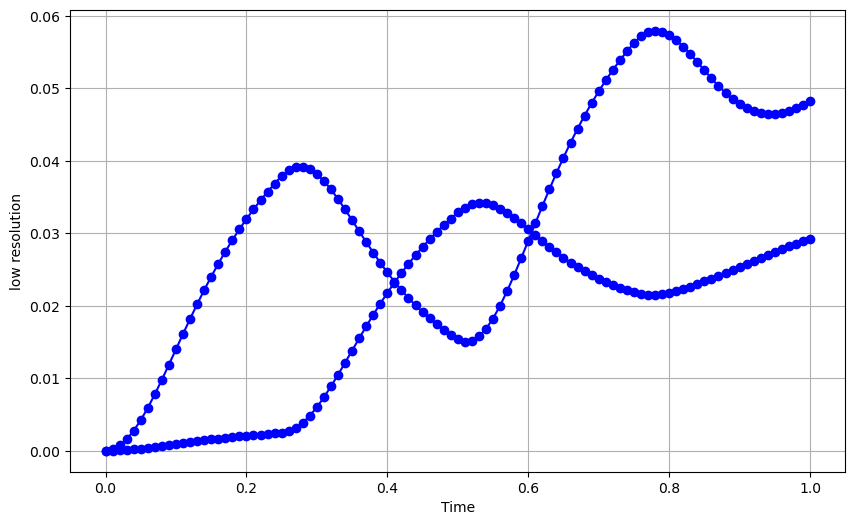

L2 norm 0.0005121434812513998


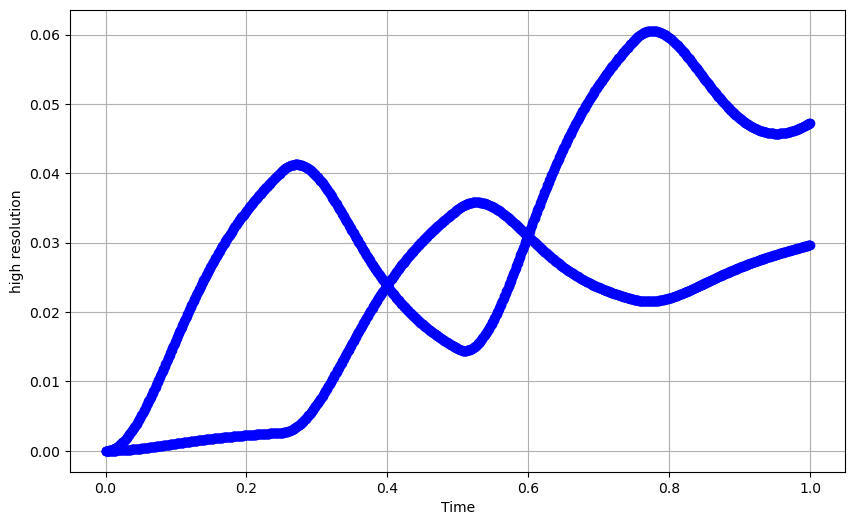

L2 norm 0.0005210796475955132


In [9]:
params = Parameters()
params.dt = 0.01
params.msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
params.V = fem.functionspace(params.msh, ("Lagrange", 1))

s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))
s2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)

control = buildControlFunction([g1, g2], [s1, s2], params)
solution_low_res = solveStateEquation(control, params)
valueInSource = np.ndarray((len(solution_low_res), 2))
for idx in range(len(solution_low_res)):
    valueInSource[idx] = getValueOfFunction(params.V, solution_low_res[idx], [params.x1, params.x2])[:,0]
plot_array(valueInSource, params.T, label='low resolution')#
print('L2 norm', calculateL2InnerProduct(solution_low_res, solution_low_res, params))

params.dt = 0.001
params.msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(128, 128),
        cell_type=mesh.CellType.triangle,
    )
params.V = fem.functionspace(params.msh, ("Lagrange", 1))
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
solution_high_res = solveStateEquation(control, params)
valueInSource = np.ndarray((len(solution_high_res), 2))
for idx in range(len(solution_high_res)):
    valueInSource[idx] = getValueOfFunction(params.V, solution_high_res[idx], [params.x1, params.x2])[:,0]
plot_array(valueInSource, params.T, label='high resolution')
print('L2 norm', calculateL2InnerProduct(solution_high_res, solution_high_res, params))

Test Solution/Adjoint operator mix

In [5]:
params = Parameters()

s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))
s2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)

control = buildControlFunction([g1, g2], [s1, s2], params)
solution = solveStateEquation(control, params)
first = calculateL2InnerProduct(solution, solution, params)

adjointState = solveAdjointEquation(solution, params)
adjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)
for idx, func in enumerate(adjointState):
	energy_form = fem.form(inner(g1, func) * dx)
	energy_local = fem.assemble_scalar(energy_form)
	energy_global = params.V.mesh.comm.allreduce(energy_local, op=MPI.SUM)
	adjointValues[idx,0] = energy_global
	energy_form = fem.form(inner(g2, func) * dx)
	energy_local = fem.assemble_scalar(energy_form)
	energy_global = params.V.mesh.comm.allreduce(energy_local, op=MPI.SUM)
	adjointValues[idx,1] = energy_global

discreteControl = np.ndarray((len(adjointState), params.d), dtype=np.float64)
interval = np.linspace(0, params.T, int(params.T / params.dt))
for idx, t in enumerate(interval):
    discreteControl[idx, 0] = s1(t)
    discreteControl[idx, 1] = s2(t)
second = 0
for idx in range(len(interval)):
    second += np.dot(adjointValues[idx], discreteControl[idx])
second /= len(interval)
print('First: ', first, ' Second: ', second)
    

First:  0.0005121434812513998  Second:  0.0005121434812513975
